In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
from __future__ import print_function
from minesweeper_game.msgame import MSGame
import os
import time
import random 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler 
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.pyplot import figure
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.utils import check_array
from minesweeper_solver import Solver
from minesweeper_game.msgame import MSGame
from minesweeper_solver.policies import corner_then_edge2_policy
from IPython.display import clear_output
import pickle

# Generate Dataset

In [41]:
"""Test script for the game board.
"""

# FeautureType: 1, Create baseline feature map from minesweeper grid without any data manipulation
def createBaseFeatures(x, y, grid, padding, fillerValue= -1):
    features = []
    for i, j in getSearchSpace(padding):
        newX = x + i
        newY = y + j
        if x == newX and y == newY:
            continue
        if len(grid) > newX >= 0 and len(grid[0]) > newY >= 0:   
            if grid[newX][newY] == 11:
                features.append(0)
            else:
                features.append(grid[newX][newY])
        else:
            features.append(fillerValue)
            
    return features


# FeautureType: 2, Create feautures using naive approach: for every square that is 11, find proportion of border squares
def createNaiveFeatures(x, y, grid, padding, fillerValue= -1):
    features = []
    for i, j in getSearchSpace(padding):
        newX = x + i
        newY = y + j
        if len(grid) > newX >= 0 and len(grid[0]) > newY >= 0:
            if grid[newX][newY] == 11:
                val = 0
                for n, m in [[-1,-1],[-1,0],[-1,1],[0,-1],[0,1],[1,-1],[1,0],[1,1]]:
                    tempX = newX + n
                    tempY = newY + m
                    if len(grid) > tempX >= 0 and len(grid[0]) > tempY >= 0:  
                        if grid[tempX][tempY] != 11 and grid[tempX][tempY] != 0:
                            val += 1
                features.append(val/8)
            else:
                features.append(grid[newX][newY])
        else:
            features.append(fillerValue)
    
    return features


# FeautureType: 3, Create feautures using Probabilistic approach: use algorithm to deduce bomb probabilities
def createProbabilityFeatures(x, y, probabilities, padding, fillerValue= -1):
    features = []
    for i, j in getSearchSpace(padding):
        newX = x + i
        newY = y + j
        if len(probabilities) > newX >= 0 and len(probabilities[0]) > newY >= 0:  
            if np.isnan(probabilities[newX][newY]):
                features.append(0)
            else:
                features.append(probabilities[newX][newY])
        else:
            features.append(fillerValue)
            
    return features   



# Generate dataset from all valid moves
def generateDataPoints(moves, grid, bombMap, featureType, padding, probabilities=None):
    data = []
    
    if featureType == 1:
        featureExtractor = createBaseFeatures
    elif featureType == 2:
        featureExtractor = createNaiveFeatures    
    elif featureType == 3:
        featureExtractor = createProbabilityFeatures

        
    for x, y in moves:
        if isValidCell(x, y, grid):
            if featureType == 3:
                feats = featureExtractor(x, y, probabilities, padding)
            else:    
                feats = featureExtractor(x, y, grid, padding)
                
            label = bombMap[x][y]
            data.append((feats, label))
    return data


# Determine if grid square has an adjacent square with value from 1-8
def isValidCell(x, y, grid):
    validVals = [i for i in range(1, 9)]
    for i, j in [[-1,-1], [-1,0], [-1, 1], [-1, 0], [-1, 1], [1, -1], [1, 0], [1,1]]:
        newX = x + i
        newY = y + j
        if newX == x and newY == y:
            continue
        if len(grid) > newX >= 0 and len(grid[0]) > newY >= 0:
            if grid[newX][newY] in validVals:
                return True
    return False


# Find all grid squares that can be clicked (value of 11)
def findValidMoves(grid):
    validMoves = []
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            if grid[i][j] == 11:
                validMoves.append([i,j])
    return validMoves


def getSearchSpace(padding):
    searchSpace = []
    for i in range(-padding, padding+1):
        for j in range(-padding, padding+1):
            searchSpace.append([i,j])
    
    return searchSpace


# Generate entire dataset with configurations  
def generateDataset(board_size_x = 16, board_size_y = 30, bombs = 99, iterations = 500, padding = 5, featureType = 1):
    dataset = []

    unique = {}    


    searchSpace = []
    for i in range(-padding, padding+1):
        for j in range(-padding, padding+1):
            searchSpace.append([i,j])

    for i in range(iterations):
        game = MSGame(board_size_x, board_size_y, bombs, verbose=False)

        if featureType == 3:
            solver = Solver(board_size_x, board_size_y, bombs)


        while game.game_status  == 2:
            moves = findValidMoves(game.get_info_map())
            choice = random.choice(moves)
            game.playAutoMove(choice[1], choice[0])

            if game.game_status == 2:
                probabilities= None
                if featureType == 3:
                    board = game.get_info_map()
                    board = np.where(board == 11, None, board)
                    probabilities = solver.solve(board)

                currentStateData = generateDataPoints(moves, game.get_info_map(), game.get_mine_map(), featureType, padding, probabilities=probabilities)


                for j, v in currentStateData:
                    unique[tuple((tuple(j),v))] = 1

                dataset.extend(currentStateData)

        if i%10 == 0:
            print('iteration: ', i, 'complete')

    clear_output(wait=True)
    print("Length of dataset: ", len(dataset))
    print("Number of unique data points: ", len(unique.items()))
    
    return dataset


In [55]:
dataset = generateDataset(iterations=1, featureType=2, padding=1)

Length of dataset:  285
Number of unique data points:  100


# Create Train & Test set

In [56]:
# Split dataset into train and test, run over sampling to increase number of bomb samples
def getTrainTest(dataset, sampling=True, test_size= 0.2):
    X = [x[0] for x in dataset]
    y = [x[1] for x in dataset]
    if sampling:
        temp = np.array(y)
        print('Before repeated sampling')
        print("samples with class non-bomb: ",len(np.where(temp == 0)[0]))
        print("samples with class bomb: ",len(np.where(temp == 1)[0]))
        
        oversample = RandomOverSampler(sampling_strategy='minority')
        X, y = oversample.fit_resample(X, y)
        
        print('After repeated sampling')
        temp = np.array(y)
        print("samples with class non-bomb: ",len(np.where(temp == 0)[0]))
        print("samples with class bomb: ",len(np.where(temp == 1)[0]))
        
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size)
    
    print('Train shape', np.shape(Xtrain),np.shape(ytrain))
    print('Test shape', np.shape(Xtest),np.shape(ytest))
    
    return Xtrain, Xtest, ytrain, ytest 


In [44]:
Xtrain, Xtest, ytrain, ytest = getTrainTest(dataset)

Before repeated sampling
samples with class non-bomb:  62
samples with class bomb:  31
After repeated sampling
samples with class non-bomb:  62
samples with class bomb:  62
Train shape (99, 120) (99,)
Test shape (25, 120) (25,)


# Train Machine Learning Models

In [50]:
# Train decision tree classifier
def trainDecisionTreeClassifier(Xtrain, ytrain):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(Xtrain, ytrain)
#     plt.figure(figsize=(30,30))  # set plot size (denoted in inches)
    
    plt.figure(figsize=(12,12))
    tree.plot_tree(clf, fontsize=10)
    plt.savefig('tree_high_dpi', dpi=100)
    
    return clf

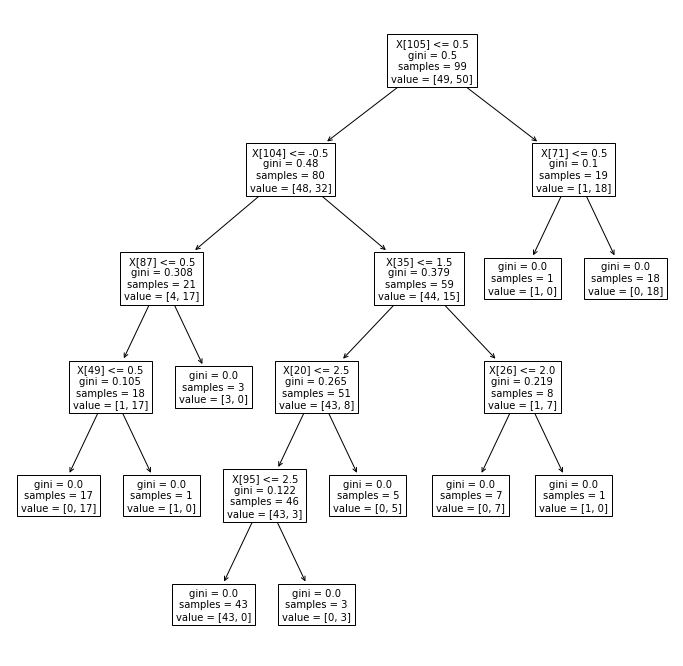

In [51]:
clf = trainDecisionTreeClassifier(Xtrain, ytrain)

In [14]:
# Train Random Forest classifier
def trainRandomForestClassifier(Xtrain, ytrain):
    clf = RandomForestClassifier(max_depth=100, random_state=0)
    clf = clf.fit(Xtrain, ytrain)
    return clf

In [15]:
clf = trainRandomForestClassifier(Xtrain, ytrain)

# Metrics

In [96]:
# Calculate accuracy of model
def accuracy(clf, Xtest, ytest):
    ypred = clf.predict(Xtest)

    return metrics.accuracy_score(ytest, ypred)

# Calculate precision of models
def precision(clf, Xtest, ytest):
    ypred = clf.predict(Xtest)

    return metrics.average_precision_score(ytest, ypred)

# Calculate f1 score of models
def f1(clf, Xtest, ytest):
    ypred = clf.predict(Xtest)

    return metrics.f1_score(ytest, ypred)

# Calculate recall of models
def recall(clf, Xtest, ytest):
    ypred = clf.predict(Xtest)

    return metrics.recall_score(ytest, ypred)

In [17]:
accuracy(clf, Xtest, ytest)

0.9798422436459246

# Simulation logic

In [18]:
# Simulate ML model in full minesweeper game, calculate percent of games solved

def simulateMLModel(board_size_x, board_size_y, bombs, model, featureType, padding, simulations=1, printBoard=False):
    
    solved = 0
    
    
    if featureType == 1:
        featureExtractor = createBaseFeatures
    elif featureType == 2:
        featureExtractor = createNaiveFeatures    
    elif featureType == 3:
        featureExtractor = createProbabilityFeatures

        
    for i in range(simulations):
        game = MSGame(board_size_x, board_size_y, bombs, verbose=False)
        
        if featureType == 3:
            solver = Solver(board_size_x, board_size_y, bombs)

        if printBoard:
            print(game.print_board())
        while game.game_status  == 2:
            moves = findValidMoves(game.get_info_map())
            moveProbabilities = []
            for move in moves:
                if featureType == 3:
                    board = game.get_info_map()
                    board = np.where(board == 11, None, board)
                    probabilities = solver.solve(board)
                    feat = featureExtractor(move[0], move[1], probabilities, padding)
                else:
                    feat = featureExtractor(move[0], move[1], game.get_info_map(), padding)
                    
                probability = model.predict_proba([feat])
                moveProbabilities.append((move, probability[0]))
            
            moveProbabilities.sort(key=lambda x:x[1][0], reverse=True)
            
            choice, nonBombProbability = moveProbabilities[0]

            game.playAutoMove(choice[1], choice[0])
            if printBoard:
                print(game.print_board())
                print("move_made: ", choice[0], choice[1])
                print("non bomb probability: ", nonBombProbability)
#                 clear_output(wait=True)
                if game.game_status == 1:
                    print('game won!!')
                elif game.game_status == 0:
                    print('game lost :(')
                time.sleep(2)
                print()
                
                
            if game.game_status == 1:
                solved += 1
        if printBoard:        
            print("MINE MAP")
            print(game.get_mine_map())
    
    return solved/ simulations

In [19]:
board_size_x = 16

board_size_y = 30

bombs = 10

simulations = 1

featureType = 1

padding = 5

simulateMLModel(board_size_x, board_size_y, bombs, clf, featureType, padding, simulations=simulations, printBoard=True)     

s       0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  

0       *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   
1       *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   
2       *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   
3       *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   
4       *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   
5       *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   
6       *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   
7       *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   
8       *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   
9       *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   
10      *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   
11      *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   
12      *   *   *   *   *   *   *   *   *   *   * 

0.0

In [20]:
# Simulate Probabilistic model in full minesweeper game, calculate percent of games solved
def simulateProbabilisticModel(board_size_x, board_size_y, bombs, simulations=1, printBoard=False):
    
    solved = 0
    for i in range(simulations):
        game = MSGame(board_size_x, board_size_y, bombs, verbose=False)
        solver = Solver(board_size_x, board_size_y, bombs)
        if printBoard:
            print(game.print_board())
        while game.game_status  == 2:
            board = game.get_info_map()
            board = np.where(board == 11, None, board)
            prob = solver.solve(board)
            
            best_prob = np.nanmin(prob)
            ys, xs = (prob == best_prob).nonzero()
            if best_prob != 0:
                x, y = corner_then_edge2_policy(prob)
                game.playAutoMove(x, y)
            else:
                # Open all the knowns.
                for x, y in zip(xs, ys):
                    if game.game_status  != 2:
                        break
                    game.playAutoMove(x, y)
                    
            if printBoard:
                print(game.print_board())
                clear_output(wait=True)
                if game.game_status == 1:
                    print('game won!!')
                elif game.game_status == 0:
                    print('game lost :(')
                time.sleep(2)
                print()
                
                
            if game.game_status == 1:
                solved += 1
        if printBoard:        
            print("MINE MAP")
            print(game.get_mine_map())
    
    return solved/ simulations


In [21]:
board_size_x = 16

board_size_y = 30

bombs = 99

simulations = 1

simulateProbabilisticModel(board_size_x, board_size_y, bombs, simulations=simulations, printBoard=True)  

game lost :(

MINE MAP
[[0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1]
 [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0]
 [0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0]
 [1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0]
 [0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 

0.0

# Collect Analytics



In [88]:
#Create 3 models with different feature extraction methods

# Use base feature extraction method, featureType = 1
d1 = generateDataset(board_size_x = 16, board_size_y = 30, bombs = 99, iterations = 500, padding = 2, featureType = 1)
d1_Xtrain, d1_Xtest, d1_ytrain, d1_ytest = getTrainTest(d1)
clf1 = trainRandomForestClassifier(d1_Xtrain, d1_ytrain)

# Use naive feature extraction method, featureType = 2
d2 = generateDataset(board_size_x = 16, board_size_y = 30, bombs = 99, iterations = 500, padding = 2, featureType = 2)
d2_Xtrain, d2_Xtest, d2_ytrain, d2_ytest = getTrainTest(d2)
clf2 = trainRandomForestClassifier(d2_Xtrain, d2_ytrain)


# Use probability extraction method, featureType = 3
d3 = generateDataset(board_size_x = 16, board_size_y = 30, bombs = 99, iterations = 500, padding = 2, featureType = 3)
d3_Xtrain, d3_Xtest, d3_ytrain, d3_ytest = getTrainTest(d3)
clf3 = trainRandomForestClassifier(d3_Xtrain, d3_ytrain)


Length of dataset:  66942
Number of unique data points:  41463
Before repeated sampling
samples with class non-bomb:  47270
samples with class bomb:  19672
After repeated sampling
samples with class non-bomb:  47270
samples with class bomb:  47270
Train shape (75632, 25) (75632,)
Test shape (18908, 25) (18908,)


In [97]:

score_dict['Model 1: test precision'] = precision(clf1, d1_Xtest, d1_ytest)
score_dict['Model 2: test precision'] = precision(clf2, d2_Xtest, d2_ytest)
score_dict['Model 3: test precision'] = precision(clf3, d3_Xtest, d3_ytest)


score_dict['Model 1: test recall'] = recall(clf1, d1_Xtest, d1_ytest)
score_dict['Model 2: test recall'] = recall(clf2, d2_Xtest, d2_ytest)
score_dict['Model 3: test recall'] = recall(clf3, d3_Xtest, d3_ytest)
         
    
score_dict['Model 1: test f1'] = f1(clf1, d1_Xtest, d1_ytest)
score_dict['Model 2: test f1'] = f1(clf2, d2_Xtest, d2_ytest)
score_dict['Model 3: test f1'] = f1(clf3, d3_Xtest, d3_ytest)
         

In [92]:
gameDifficulties = {'Easy':{'board_size_x': 9, 'board_size_y': 9, 'bombs':5 }, 'Beginner':{'board_size_x': 9, 'board_size_y': 9, 'bombs':10 }, 'Intermediate ':{'board_size_x': 16, 'board_size_y': 16, 'bombs':40 }, 'reduced_Expert':{'board_size_x': 16, 'board_size_y': 30, 'bombs':20 },  'Expert':{'board_size_x': 16, 'board_size_y': 30, 'bombs':99 }}

simulations = 100

score_dict = {}

score_dict['Model 1: test accuracy'] = accuracy(clf1, d1_Xtest, d1_ytest)
score_dict['Model 2: test accuracy'] = accuracy(clf2, d2_Xtest, d2_ytest)
score_dict['Model 3: test accuracy'] = accuracy(clf3, d3_Xtest, d3_ytest)
         

for difficulty in gameDifficulties.keys():
    print('Running simulations for ', difficulty)
    
    score = simulateMLModel(gameDifficulties[difficulty]['board_size_x'], gameDifficulties[difficulty]['board_size_y'], gameDifficulties[difficulty]['bombs'], clf1, 1, padding = 2, simulations=simulations, printBoard=False)    
    score_dict['Model 1: '+ difficulty] = score
    
    score= simulateMLModel(gameDifficulties[difficulty]['board_size_x'], gameDifficulties[difficulty]['board_size_y'], gameDifficulties[difficulty]['bombs'], clf2, 2, padding = 2,  simulations=simulations, printBoard=False)    
    score_dict['Model 2: '+ difficulty] = score
    
    score = simulateMLModel(gameDifficulties[difficulty]['board_size_x'], gameDifficulties[difficulty]['board_size_y'], gameDifficulties[difficulty]['bombs'], clf3, 3, padding = 2, simulations=simulations, printBoard=False)    
    score_dict['Model 3: '+ difficulty] = score
   
    score = simulateProbabilisticModel(gameDifficulties[difficulty]['board_size_x'], gameDifficulties[difficulty]['board_size_y'], gameDifficulties[difficulty]['bombs'], simulations=simulations, printBoard=False)  
    score_dict['Probabilistic Model: '+difficulty] = score
    

Running simulations for  Easy
Running simulations for  Beginner
Running simulations for  Intermediate 
Running simulations for  reduced_Expert
Running simulations for  Expert


In [94]:
with open('model.pkl','wb') as f:
    pickle.dump(clf1,f)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


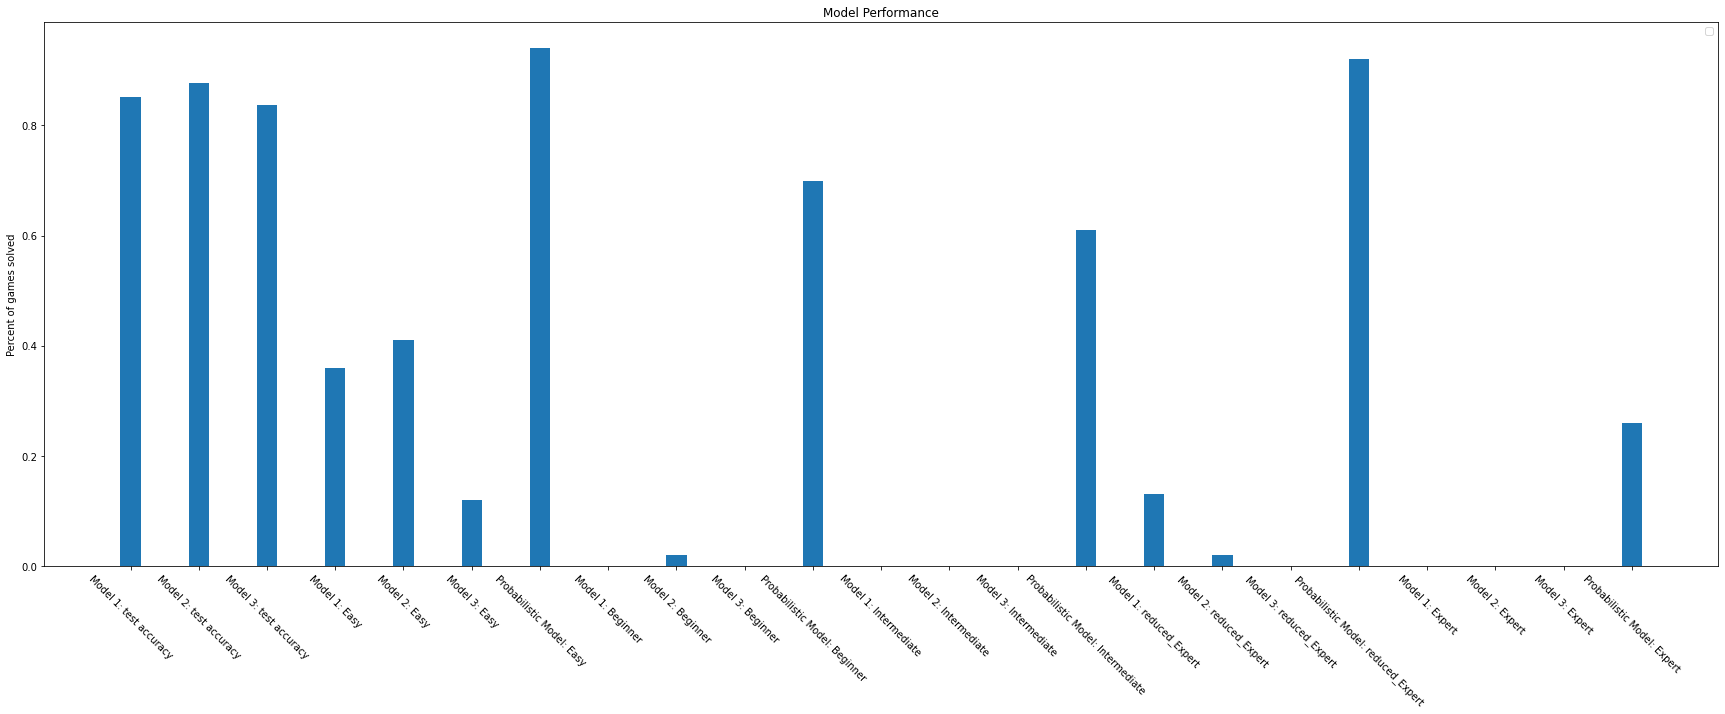

In [93]:
x = np.arange(len(score_dict))
width = 0.3

plt.figure(figsize=(30,10))

plt.title("Model Performance")

plt.ylabel('Percent of games solved')
plt.bar(x, score_dict.values(), width)
plt.xticks(ticks=x, labels=score_dict.keys(),
           rotation=-45)
_ = plt.legend()
plt.savefig('images/Performance2.jpg')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


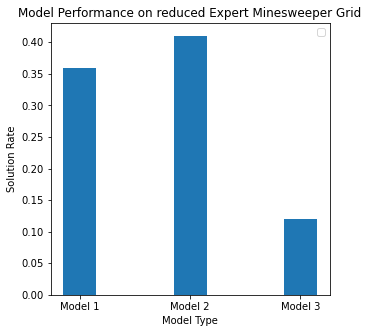

In [109]:
vals = [score_dict['Model 1: Easy'], score_dict['Model 2: Easy'], score_dict['Model 3: Easy']]
labels = ['Model 1', 'Model 2', 'Model 3']
x = np.arange(len(vals))
width = 0.3

plt.figure(figsize=(5,5))

plt.title("Model Performance on reduced Expert Minesweeper Grid")

plt.ylabel('Solution Rate')
plt.xlabel('Model Type')
plt.bar(x, vals, width)
plt.xticks(ticks=x, labels=labels)
_ = plt.legend()
plt.savefig('images/reducedExpertMinesweeperJustML.jpg')
plt.show()


In [86]:
padding_score_dict = []
simulations = 100

# Use naive feature extraction method, featureType = 2
d1 = generateDataset(board_size_x = 16, board_size_y = 30, bombs = 99, iterations = 500, padding = 1, featureType = 1)
d1_Xtrain, d1_Xtest, d1_ytrain, d1_ytest = getTrainTest(d1)
clf1 = trainRandomForestClassifier(d1_Xtrain, d1_ytrain)
score = simulateMLModel(9, 9, 5, clf1, 1, padding = 1, simulations=simulations, printBoard=False)    
padding_score_dict.append(score)

d1 = generateDataset(board_size_x = 16, board_size_y = 30, bombs = 99, iterations = 500, padding = 2, featureType = 1)
d1_Xtrain, d1_Xtest, d1_ytrain, d1_ytest = getTrainTest(d1)
clf1 = trainRandomForestClassifier(d1_Xtrain, d1_ytrain)
score = simulateMLModel(9, 9, 5, clf1, 1, padding = 2, simulations=simulations, printBoard=False)    
padding_score_dict.append(score)


d1 = generateDataset(board_size_x = 16, board_size_y = 30, bombs = 99, iterations = 500, padding = 3, featureType = 1)
d1_Xtrain, d1_Xtest, d1_ytrain, d1_ytest = getTrainTest(d1)
clf1 = trainRandomForestClassifier(d1_Xtrain, d1_ytrain)
score = simulateMLModel(9, 9, 5, clf1, 1, padding = 3, simulations=simulations, printBoard=False)    
padding_score_dict.append(score)


d1 = generateDataset(board_size_x = 16, board_size_y = 30, bombs = 99, iterations = 500, padding = 4, featureType = 1)
d1_Xtrain, d1_Xtest, d1_ytrain, d1_ytest = getTrainTest(d1)
clf1 = trainRandomForestClassifier(d1_Xtrain, d1_ytrain)
score = simulateMLModel(9, 9, 5, clf1, 1, padding = 4, simulations=simulations, printBoard=False)    
padding_score_dict.append(score)


d1 = generateDataset(board_size_x = 16, board_size_y = 30, bombs = 99, iterations = 500, padding = 5, featureType = 1)
d1_Xtrain, d1_Xtest, d1_ytrain, d1_ytest = getTrainTest(d1)
clf1 = trainRandomForestClassifier(d1_Xtrain, d1_ytrain)
score = simulateMLModel(9, 9, 5, clf1, 1, padding = 5, simulations=simulations, printBoard=False)    
padding_score_dict.append(score)




Length of dataset:  77575
Number of unique data points:  32291
Before repeated sampling
samples with class non-bomb:  54354
samples with class bomb:  23221
After repeated sampling
samples with class non-bomb:  54354
samples with class bomb:  54354
Train shape (86966, 120) (86966,)
Test shape (21742, 120) (21742,)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


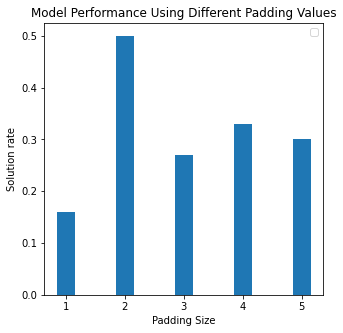

In [111]:

plt.figure(figsize=(5, 5))

plt.title("Model Performance Using Different Padding Values")

labels = [1, 2, 3, 4, 5]
x = np.arange(len(padding_score_dict))
plt.ylabel('Solution rate')
plt.xlabel('Padding Size')
plt.bar(x, padding_score_dict, width=0.3)
plt.xticks(ticks=x, labels=labels, 
           rotation=0)
_ = plt.legend()
plt.savefig('images/PaddingModels.jpg', dpi=100)
plt.show()
